# Capstone Two - 3 Exploratory Data Analysis<a id='3'></a>

## 3.1 Contents<a id='3.1'></a>
* [3 Exploratory Data Analysis](#3)
  * [3.1 Contents](#3.1)
  * [3.2 Imports](#3.2)
  * [3.3 Load The Data](#3.3)
  * [3.4 Explore The Data](#3.4)
    * [3.4.1 Missing Values and Time Gaps](#3.4.1)
      * [3.4.1.1 Store Sales](#3.4.1.1)
      * [3.4.1.2 Daily Oil Price](#3.4.1.2)
      * [3.4.1.3 Transactions](#3.4.1.3)
    * [3.4.2 Oil Price Features](#3.4.2)
    * [3.4.3 Holiday Features](#3.4.3)
    * [3.4.4 All Features](#3.4.4)
  * [3.5 Save data](#2.5)
  * [3.6 Summary](#2.6)

## 3.2 Imports<a id='3.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

from library.sb_utils import save_file

## 3.3 Load The Data<a id='3.3'></a>

In [2]:
# Directory of data
input_dir = '../input_data/store-sales-time-series-forecasting/'
data_dir = '../data/'

In [3]:
# Store sales (training set)
train = pd.read_csv(input_dir+'train.csv')

# Store sales (testing set)
test = pd.read_csv(input_dir+'test.csv')

# Store metadata
stores = pd.read_csv(input_dir+'stores.csv')

# Daily oil price
oil = pd.read_csv(input_dir+'oil.csv')

# Number of daily transactions at a store
transactions = pd.read_csv(input_dir+'transactions.csv')

# Cleaned Holidays and Events data
holidays = pd.read_csv(data_dir+'holidays_events_cleaned.csv')

## 3.4 Explore The Data<a id='3.4'></a>

### 3.4.1 Missing Values and Time Gaps<a id='3.4.1'></a>

#### 3.4.1.1 Store Sales<a id='3.4.1.1'></a>

In [4]:
missing_train = train.isnull().sum()
missing_train

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [5]:
missing_test = test.isnull().sum()
missing_test

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

There're **no missing values** in the training and test sets.

In [6]:
# Get dates of training set as a calendar
train_dates = train.date
train_dates.drop_duplicates(inplace=True)
calendar = pd.DataFrame(train_dates).reset_index(drop=True)
print(calendar.shape)
calendar.head()

(1684, 1)


,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [7]:
# Check how many days are actually in the training set.
d0 = datetime.date(2013, 1, 1)
d1 = datetime.date(2017, 8, 16)
dd = d1 - d0 #day difference
dd

datetime.timedelta(days=1688)

We can there are actually 1688 days, but the `calendar` only has 1684, so there are **4 time gaps**.

In [8]:
dates = pd.to_datetime(calendar['date'])
df_dates = pd.DataFrame(dates, columns=['date'])

# Take the diff of the date column (drop 1st row since it's undefined)
deltas = df_dates['date'].diff()[1:]

# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > datetime.timedelta(days=1)]

# Print results
print(f'{len(gaps)} time gaps in total:')
for i, g in gaps.iteritems():
    gap_start = df_dates['date'][i-1]
    print(f'Start: {datetime.datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')

4 time gaps in total:
Start: 2013-12-24 | Duration: 2 days, 0:00:00
Start: 2014-12-24 | Duration: 2 days, 0:00:00
Start: 2015-12-24 | Duration: 2 days, 0:00:00
Start: 2016-12-24 | Duration: 2 days, 0:00:00


In [9]:
train[train['date'].isin(['2013-12-25','2014-12-25','2015-12-25','2016-12-25'])]

,id,date,store_nbr,family,sales,onpromotion


The normal time step is 1 day. The above "2 days" gap after every Christmas Eve (12-24) means that all stores were closed on Christmas Day (No sales data on "12-25"). Therefore, we can **ignore these 4 "Christmas Day" time gaps**.

#### 3.4.1.2 Daily Oil Price<a id='3.4.1.2'></a>

From Data Wrangling, we know there are missings value and time gaps in the oil price data.

In [10]:
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


The **time gaps** in tha above data are "2013-01-05 to 2013-01-06" and "2013-01-12 to 2013-01-13". It looks like there are no oil price data on the weekend. We need to verify it.

In [11]:
calendar['day_of_week'] = pd.to_datetime(calendar['date']).dt.day_name()
calendar_oil = calendar.merge(oil, how="left", on='date') 
calendar_oil.head(15)

,date,day_of_week,dcoilwtico
0,2013-01-01,Tuesday,NaN
1,2013-01-02,Wednesday,93.14
2,2013-01-03,Thursday,92.97
3,2013-01-04,Friday,93.12
4,2013-01-05,Saturday,NaN
5,2013-01-06,Sunday,NaN
6,2013-01-07,Monday,93.20
7,2013-01-08,Tuesday,93.21
8,2013-01-09,Wednesday,93.08
9,2013-01-10,Thursday,93.81


We can see there are indeed **no oil price data for the weekends**.

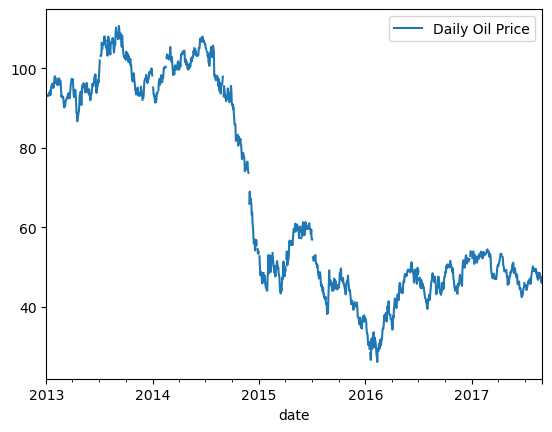

In [12]:
# Look at the oil price over the past years
oil_plt = oil
oil_plt['date'] = pd.to_datetime(oil_plt['date'])
oil_plt.plot(x = "date", y = "dcoilwtico", kind='line', label='Daily Oil Price')
plt.show()

Since Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices and the oil price fell sharply in 2014, we can try to **start our training set from "2015-01-01"**. Actually the data before this date were quite irrelevant because our target is to predict only 16 days after the training set.

Use Forward Fill to fill the NaNs:

In [13]:
calendar_oil['dcoilwtico'].fillna(method = 'ffill', inplace = True)
missing_oil = calendar_oil.isnull().sum()
missing_oil

date           0
day_of_week    0
dcoilwtico     1
dtype: int64

In [14]:
calendar_oil.dtypes

date            object
day_of_week     object
dcoilwtico     float64
dtype: object

There is only one missing value in the first date (2013-01-01). We just leave it alone for now.

#### 3.4.1.3 Transactions<a id='3.4.1.3'></a>

In [15]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [16]:
missing_trans = transactions.isnull().sum()
missing_trans

date            0
store_nbr       0
transactions    0
dtype: int64

There are no missing values in the tranactions data.

We can see there was only store No. 25 has transactions on 2013-01-01. We check this in the training data:

In [17]:
train[ (train['date'] == '2013-01-01') & (train['sales'] != 0) ]

,id,date,store_nbr,family,sales,onpromotion
563,563,2013-01-01,25,BEAUTY,2.000000,0
564,564,2013-01-01,25,BEVERAGES,810.000000,0
566,566,2013-01-01,25,BREAD/BAKERY,180.589000,0
568,568,2013-01-01,25,CLEANING,186.000000,0
569,569,2013-01-01,25,DAIRY,143.000000,0
570,570,2013-01-01,25,DELI,71.090000,0
571,571,2013-01-01,25,EGGS,46.000000,0
572,572,2013-01-01,25,FROZEN FOODS,29.654999,0
573,573,2013-01-01,25,GROCERY I,700.000000,0
574,574,2013-01-01,25,GROCERY II,15.000000,0


Now check if there're any **time gaps** in the transaction data:

In [18]:
transactions['date'].nunique()

1682

The number of unique dates is less than 1684, indicating there're time gaps of **two days**.

In [19]:
dates = pd.to_datetime(transactions['date'])
df_dates = pd.DataFrame(dates, columns=['date'])

# Take the diff of the date column (drop 1st row since it's undefined)
deltas = df_dates['date'].diff()[1:]

# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > datetime.timedelta(days=1)]

# Print results
print(f'{len(gaps)} time gaps in total:')
for i, g in gaps.iteritems():
    gap_start = df_dates['date'][i-1]
    print(f'Start: {datetime.datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')

6 time gaps in total:
Start: 2013-12-24 | Duration: 2 days, 0:00:00
Start: 2014-12-24 | Duration: 2 days, 0:00:00
Start: 2015-12-24 | Duration: 2 days, 0:00:00
Start: 2015-12-31 | Duration: 2 days, 0:00:00
Start: 2016-01-02 | Duration: 2 days, 0:00:00
Start: 2016-12-24 | Duration: 2 days, 0:00:00


Time step with no tranactions date: 2016-01-01 and 2016-01-03.

In [20]:
train[ (train['date'] == '2016-01-01') & (train['sales'] != 0) ]

,id,date,store_nbr,family,sales,onpromotion
1946505,1946505,2016-01-01,25,AUTOMOTIVE,4.000,0
1946507,1946507,2016-01-01,25,BEAUTY,13.000,0
1946508,1946508,2016-01-01,25,BEVERAGES,5104.000,1
1946510,1946510,2016-01-01,25,BREAD/BAKERY,680.952,0
1946511,1946511,2016-01-01,25,CELEBRATION,13.000,0
1946512,1946512,2016-01-01,25,CLEANING,734.000,0
1946513,1946513,2016-01-01,25,DAIRY,1033.000,11
1946514,1946514,2016-01-01,25,DELI,295.181,47
1946515,1946515,2016-01-01,25,EGGS,230.000,24
1946516,1946516,2016-01-01,25,FROZEN FOODS,596.125,0


We can see there was only store No.25 has transactions on 2016-01-01. We guess that only store No.25 was open on Jan. 1 every year.

In [21]:
train[ (train['date'].isin(['2014-01-01']) ) & (train['sales'] != 0) ]['store_nbr'].unique()

array([25, 36])

In [22]:
train[ (train['date'].isin(['2015-01-01']) ) & (train['sales'] != 0) ]['store_nbr'].unique()

array([25])

In [23]:
train[ (train['date'].isin(['2017-01-01']) ) & (train['sales'] != 0) ]['store_nbr'].unique()

array([25])

We can see that store No.36 was open on 2014-01-01, and only store No.25 was open on every Jan. 1.

In [24]:
train[ (train['date'] == '2016-01-03') & (train['sales'] != 0) ]

,id,date,store_nbr,family,sales,onpromotion
1949508,1949508,2016-01-03,1,AUTOMOTIVE,1.000,0
1949510,1949510,2016-01-03,1,BEAUTY,2.000,0
1949511,1949511,2016-01-03,1,BEVERAGES,1048.000,1
1949513,1949513,2016-01-03,1,BREAD/BAKERY,138.275,1
1949514,1949514,2016-01-03,1,CELEBRATION,5.000,0
...,...,...,...,...,...,...
1951285,1951285,2016-01-03,9,POULTRY,748.386,0
1951286,1951286,2016-01-03,9,PREPARED FOODS,143.022,0
1951287,1951287,2016-01-03,9,PRODUCE,3015.563,0
1951288,1951288,2016-01-03,9,SCHOOL AND OFFICE SUPPLIES,13.000,0


There were many stores opened on 2016-01-03, but the transactions data were missing on this date.

### 3.4.2 Oil Price Features<a id='3.4.2'></a>

In [25]:
calendar_oil['oil_lag1'] = calendar_oil['dcoilwtico'].shift(1)
calendar_oil['oil_lag2'] = calendar_oil['dcoilwtico'].shift(2)
calendar_oil['oil_lag3'] = calendar_oil['dcoilwtico'].shift(3)
calendar_oil['oil_lag4'] = calendar_oil['dcoilwtico'].shift(4)
calendar_oil['oil_week_avg'] = calendar_oil['dcoilwtico'].rolling(7).mean()

In [26]:
calendar_oil.head(10)

,date,day_of_week,dcoilwtico,oil_lag1,oil_lag2,oil_lag3,oil_lag4,oil_week_avg
0,2013-01-01,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,Wednesday,93.14,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,Thursday,92.97,93.14,NaN,NaN,NaN,NaN
3,2013-01-04,Friday,93.12,92.97,93.14,NaN,NaN,NaN
4,2013-01-05,Saturday,93.12,93.12,92.97,93.14,NaN,NaN
5,2013-01-06,Sunday,93.12,93.12,93.12,92.97,93.14,NaN
6,2013-01-07,Monday,93.20,93.12,93.12,93.12,92.97,NaN
7,2013-01-08,Tuesday,93.21,93.20,93.12,93.12,93.12,93.125714
8,2013-01-09,Wednesday,93.08,93.21,93.20,93.12,93.12,93.117143
9,2013-01-10,Thursday,93.81,93.08,93.21,93.20,93.12,93.237143


### 3.4.3 Holiday Features<a id='3.4.3'></a>

### 3.4.4 All Features<a id='3.4.4'></a>

**Merge datasets into one dataframe:**

In [27]:
df_train = train.merge(stores, how="left", on='store_nbr')   
df_train = df_train.merge(calendar_oil, how="left", on='date')      
df_train = df_train.merge(transactions, how="left", on=['date','store_nbr'])  
df_train = df_train.merge(holidays,on='date',how='left')

# Rename cloumns with the same name
df_train = df_train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

print(df_train.shape)
df_train.head()

(3000888, 20)


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,day_of_week,dcoilwtico,oil_lag1,oil_lag2,oil_lag3,oil_lag4,oil_week_avg,transactions,holiday_type,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,False


In [28]:
# Split the date column
df_train.date = pd.to_datetime(df_train.date)
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['quarter'] = df_train['date'].dt.quarter
# data['day_of_week'] = df_train['date'].dt.day_name()
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,oil_lag3,oil_lag4,oil_week_avg,transactions,holiday_type,transferred,year,month,week,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,Holiday,False,2013,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,Holiday,False,2013,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,Holiday,False,2013,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,Holiday,False,2013,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,Holiday,False,2013,1,1,1


In [29]:
# Number Of Missing Values By Column
df_miss = df_train.drop(['holiday_type','transferred'], axis=1)
missing = pd.concat([df_miss.isnull().sum(), 100 * df_miss.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
transactions,245784,8.190376
oil_week_avg,12474,0.415677
oil_lag4,8910,0.296912
oil_lag3,7128,0.237530
oil_lag2,5346,0.178147
oil_lag1,3564,0.118765
dcoilwtico,1782,0.059382
date,0,0.000000
week,0,0.000000
month,0,0.000000
